
# **Sistema de Decisión Predictiva para Riesgo de Anemia**

**Autoras:**

*   Giraldo Meza Shulay Tamirha
*   Ramon Medina Katherine Lisbeth

**Fecha:** Octubre 2025

**Estructura:**
1) Carga y validación
2) Limpieza y preprocesamiento
3) Feature engineering
4) Ejecución del algoritmo
5) Exportación de resultados

**Ejecución:**
Subir el dataset a la carpeta input/ y correr todas las celdas.

**BLOQUE 1 - CARGA Y VALIDACIÓN**

**Objetivo**

Cargar el dataset desde `input/` y validar que su esquema y contenidos cumplen los requisitos mínimos para el pipeline.
Evitar errores posteriores por formatos o datos inesperados.

**Contiene:**

1.1 Configuración de rutas y parámetros.  
1.2 Carga segura del CSV (con manejo de errores).  
1.3 Validación de esquema (columnas requeridas, tipos esperados).  
1.4 Verificación de integridad (filas duplicadas, nulos, pequeños checks de rango).  
1.5 Generación de reporte de validación (pantalla + archivo `output/validation_report.json`).

**Instrucciones:** Colocar el CSV en `/content/idl3_proyecto/input/` antes de ejecutar este notebook. Ejecutar todas las celdas de este bloque.


In [1]:
# =========================================================
# BLOQUE 1 — CARGA Y VALIDACIÓN
# =========================================================

# Ejecutar esta celda después de subir el CSV a /content/idl3_proyecto/input/

import os, json, textwrap
from pathlib import Path
import pandas as pd
import numpy as np
import datetime

# ---------------------------
# 1.1 Configuración de rutas y parámetros
# ---------------------------
BASE_DIR = '/content/idl3_proyecto'
INPUT_DIR = os.path.join(BASE_DIR, 'input')
OUTPUT_DIR = os.path.join(BASE_DIR, 'output')
ARTIFACTS_DIR = os.path.join(BASE_DIR, 'artifacts')

os.makedirs(INPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# Nombre de archivo esperado. Si no existe, listamos los csv disponibles.
EXPECTED_FILENAME = 'dataset_anemia_peru_midis_2025.csv'

# Configuración de validación (columnas requeridas y tipos esperados).
# Puedes modificar según lo definas en tu documentación.
SCHEMA_EXPECTED = {
    # 'column_name': 'type'  # tipos esperados: 'numeric', 'categorical', 'any'
    "Hemoglobina_g_dL": "numeric",
    "Edad_meses": "numeric",
    "Sexo": "categorical",
    "Departamento": "categorical",   # opcional, pero útil para políticas territoriales
    "Anemia": "categorical"          # target (0/1 o 'Si'/'No')
}

In [2]:
# ---------------------------
# 1.2 Carga segura del CSV
# ---------------------------

def find_input_file(expected_name=EXPECTED_FILENAME, folder=INPUT_DIR):
    path_expected = os.path.join(folder, expected_name)
    if os.path.exists(path_expected):
        return path_expected
    # si no está, busca el primer csv
    csvs = sorted(Path(folder).glob("*.csv"))
    if len(csvs) == 0:
        raise FileNotFoundError(f"No se encontró ningún .csv en {folder}. Por favor sube el dataset.")
    print(f"Nota: no se encontró {expected_name}. Usando {csvs[0].name} como archivo de entrada.")
    return str(csvs[0])

# Intentar cargar
input_file = find_input_file()
print("Archivo de entrada detectado:", input_file)

# Cargar con pandas (con encoding y manejo de separadores común)
def safe_read_csv(path, nrows_preview=5):
    # intentos: coma, punto y coma
    try:
        df = pd.read_csv(path)
        return df
    except Exception as e1:
        try:
            df = pd.read_csv(path, sep=';')
            return df
        except Exception as e2:
            raise ValueError(f"No se pudo leer el CSV. Errores:\n- {e1}\n- {e2}")

df = safe_read_csv(input_file)
print(f"Data cargada: {df.shape[0]} filas x {df.shape[1]} columnas.")

Archivo de entrada detectado: /content/idl3_proyecto/input/dataset_anemia_peru_midis_2025.csv
Data cargada: 200000 filas x 29 columnas.


In [3]:
# ---------------------------
# 1.3 Validación de esquema (columnas requeridas, tipos esperados)
# ---------------------------

validation = {}
validation['run_timestamp'] = datetime.datetime.utcnow().isoformat() + "Z"
validation['input_file'] = input_file
validation['n_rows'] = int(df.shape[0])
validation['n_columns'] = int(df.shape[1])
validation['columns_present'] = list(df.columns)

# Columnas faltantes
expected_cols = list(SCHEMA_EXPECTED.keys())
missing_columns = [c for c in expected_cols if c not in df.columns]
validation['missing_columns'] = missing_columns

# Tipos detectados (pandas dtypes)
detected_types = {c: str(df[c].dtype) for c in df.columns}
validation['detected_types'] = detected_types

# Para cada columna esperada
col_checks = {}
for col, expected in SCHEMA_EXPECTED.items():
    info = {}
    if col not in df.columns:
        info['present'] = False
        col_checks[col] = info
        continue
    info['present'] = True
    s = df[col]
    info['n_null'] = int(s.isnull().sum())
    info['pct_null'] = float(s.isnull().mean())
    # tipo heurístico
    if expected == 'numeric':
        # comprobar que la columna sea convertible a numérica
        coerced = pd.to_numeric(s, errors='coerce')
        n_non_numeric = int(coerced.isnull().sum() - s.isnull().sum())
        info['n_non_numeric'] = n_non_numeric
        if s.dtype.kind in 'biufc':
            info['dtype_ok'] = True
        else:
            info['dtype_ok'] = (n_non_numeric == 0)
        # stats básicos
        try:
            stats = {
                'min': float(coerced.min()),
                'q1': float(coerced.quantile(0.25)),
                'median': float(coerced.median()),
                'mean': float(coerced.mean()),
                'q3': float(coerced.quantile(0.75)),
                'max': float(coerced.max()),
                'std': float(coerced.std())
            }
        except Exception:
            stats = {}
        info['stats'] = stats
    elif expected == 'categorical':
        # cardinalidad, valores únicos más frecuentes
        num_unique = int(s.nunique(dropna=True))
        top_values = s.value_counts(dropna=True).head(10).to_dict()
        info['n_unique'] = num_unique
        info['top_values'] = top_values
        # dtype_ok es True si no es claramente numérico
        info['dtype_ok'] = not (s.dtype.kind in 'biufc')
    else:
        info['dtype_ok'] = True  # any
    col_checks[col] = info

validation['column_checks'] = col_checks

/tmp/ipython-input-2407804267.py:6: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  validation['run_timestamp'] = datetime.datetime.utcnow().isoformat() + "Z"


In [4]:
# ---------------------------
# 1.4 Verificación de integridad (duplicados, nulos globales y filas vacías)
# ---------------------------
integrity = {}
integrity['n_duplicates'] = int(df.duplicated().sum())
integrity['pct_duplicates'] = float(df.duplicated().mean())
integrity['n_rows_allnull'] = int((df.isnull().all(axis=1)).sum())
integrity['pct_rows_allnull'] = float((df.isnull().all(axis=1)).mean())

# Filas con muchos nulos (umbral configurable, aquí 50% de columnas)
threshold = int(0.5 * df.shape[1])
integrity['n_rows_manynull'] = int((df.isnull().sum(axis=1) > threshold).sum())

validation['integrity'] = integrity

In [5]:
# ---------------------------
# 1.5 Reglas de chequeo adicional (alertas)
# ---------------------------
alerts = []
# Si faltan columnas requeridas -> alerta crítica
if missing_columns:
    alerts.append({'level': 'CRITICAL', 'msg': f'FALTAN COLUMNAS REQUERIDAS: {missing_columns}'})

# Si target tiene muchas categorías o no binario -> alerta
target_col = None
if 'Anemia' in df.columns:
    target_col = 'Anemia'
elif len(df.columns) > 0 and 'Anemia' in SCHEMA_EXPECTED:
    target_col = 'Anemia'
else:
    # inferir posible target como última columna si es binaria-ish
    lastcol = df.columns[-1]
    if df[lastcol].dropna().nunique() <= 3:
        target_col = lastcol

if target_col:
    unique_vals = df[target_col].dropna().unique().tolist()
    if len(unique_vals) > 3:
        alerts.append({'level': 'WARNING', 'msg': f'TARGET {target_col} tiene >3 valores: {unique_vals}. Verificar codificación.'})
else:
    alerts.append({'level': 'CRITICAL', 'msg': 'No se detectó un target obvio. Especifica la columna objetivo en SCHEMA_EXPECTED o renombra la columna objetivo.'})

# Outliers extremos en hemoglobina (criterio fisico: hb < 4 o > 25 g/dL improbable)
if 'Hemoglobina_g_dL' in df.columns:
    hb = pd.to_numeric(df['Hemoglobina_g_dL'], errors='coerce')
    n_extreme = int(((hb < 3) | (hb > 25)).sum())
    if n_extreme > 0:
        alerts.append({'level': 'WARNING', 'msg': f'{n_extreme} filas con Hemoglobina fuera de rango fisiológico [3,25] g/dL.'})

validation['alerts'] = alerts


In [6]:
# ---------------------------
# Guardar reporte de validación
# ---------------------------
report_path = os.path.join(OUTPUT_DIR, 'validation_report.json')
with open(report_path, 'w', encoding='utf-8') as f:
    json.dump(validation, f, indent=2, ensure_ascii=False)

# También permitir guardado en CSV resumen (más legible)
summary_rows = []
for col, info in col_checks.items():
    row = {
        'column': col,
        'present': info.get('present', False),
        'n_null': info.get('n_null', None),
        'pct_null': info.get('pct_null', None),
        'dtype_ok': info.get('dtype_ok', None),
        'notes': ''
    }
    if 'n_non_numeric' in info and info['n_non_numeric']>0:
        row['notes'] += f"n_non_numeric={info['n_non_numeric']}; "
    if 'n_unique' in info:
        row['notes'] += f"n_unique={info.get('n_unique')}; "
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
summary_csv_path = os.path.join(OUTPUT_DIR, 'validation_summary.csv')
summary_df.to_csv(summary_csv_path, index=False)

In [7]:
# ---------------------------
# Mostrar resultados resumidos en pantalla
# ---------------------------
print("\n--- RESUMEN RÁPIDO DE VALIDACIÓN ---")
print(f"Filas: {validation['n_rows']}, Columnas: {validation['n_columns']}")
print("Columnas faltantes (si las hay):", validation['missing_columns'])
print("Duplicados:", validation['integrity']['n_duplicates'], f"({validation['integrity']['pct_duplicates']*100:.2f}% )")
print("Filas con >50% nulos:", validation['integrity']['n_rows_manynull'])
print("\nTop alerts:")
for a in validation['alerts'][:5]:
    print("-", a['level'], ":", a['msg'])

print("\nValidation report guardado en:", report_path)
print("Resumen CSV guardado en:", summary_csv_path)

# Mostrar sample de las primeras filas
display_df = df.head(5).copy()
display_df.index.name = 'row_index'
print("\nPrimeras filas del dataset (preview):")
print(display_df.to_string())


--- RESUMEN RÁPIDO DE VALIDACIÓN ---
Filas: 200000, Columnas: 29
Columnas faltantes (si las hay): ['Departamento']
Duplicados: 0 (0.00% )
Filas con >50% nulos: 0

Top alerts:
- CRITICAL : FALTAN COLUMNAS REQUERIDAS: ['Departamento']
- WARNING : TARGET Anemia tiene >3 valores: ['Leve', 'No', 'Severa', 'Moderada']. Verificar codificación.

Validation report guardado en: /content/idl3_proyecto/output/validation_report.json
Resumen CSV guardado en: /content/idl3_proyecto/output/validation_summary.csv

Primeras filas del dataset (preview):
           ID                      Nombre  Edad_meses Sexo    Region    Provincia    Distrito    Area            Clima  Altitud_m Fecha_Registro Programa_QaliWarma Programa_Juntos Programa_VasoLeche Suplemento_Hierro  Ingreso_Familiar_Soles Nivel_Educacion_Madre  Nro_Hijos Vivienda_Material  Peso_kg  Talla_cm Estado_Nutricional Actividad_Madre Acceso_Informacion Lugar_Atencion Condicion_Vivienda  Hemoglobina_g_dL Anemia Riesgo_Anemia
row_index           

**BLOQUE 2 — LIMPIEZA Y PREPROCESAMIENTO**

**Objetivo**

Detectar valores faltantes, outliers y errores de formato en los datos originales.  
Aplicar reglas de limpieza e imputación para garantizar la coherencia de las variables que se usarán en el modelado.

**Contiene**

2.1 Análisis de valores faltantes y duplicados  
2.2 Imputación de variables numéricas y categóricas  
2.3 Tratamiento de outliers   
2.4 Normalización o estandarización preliminar   
2.5 Reporte de limpieza y resumen estadístico

In [8]:
# =========================================================
# BLOQUE 2 — LIMPIEZA Y PREPROCESAMIENTO
# =========================================================

import pandas as pd
import numpy as np
import os, json
from sklearn.preprocessing import StandardScaler

print("=== BLOQUE 2: INICIANDO LIMPIEZA Y PREPROCESAMIENTO ===")

# Rutas
input_file = os.path.join(INPUT_DIR, EXPECTED_FILENAME)
df = pd.read_csv(input_file)
print(f"Dataset original cargado: {df.shape[0]} filas x {df.shape[1]} columnas")

# =========================================================
# 2.1 Análisis de valores faltantes y duplicados
# =========================================================

missing_pct = df.isnull().mean().sort_values(ascending=False) * 100
print("\nPorcentaje de valores faltantes por variable (top 10):")
print(missing_pct.head(10))

n_duplicates = df.duplicated().sum()
print(f"\nDuplicados detectados: {n_duplicates}")
if n_duplicates > 0:
    df = df.drop_duplicates()
    print(f"Duplicados eliminados. Nuevo tamaño: {df.shape}")


=== BLOQUE 2: INICIANDO LIMPIEZA Y PREPROCESAMIENTO ===
Dataset original cargado: 200000 filas x 29 columnas

Porcentaje de valores faltantes por variable (top 10):
ID            0.0
Nombre        0.0
Edad_meses    0.0
Sexo          0.0
Region        0.0
Provincia     0.0
Distrito      0.0
Area          0.0
Clima         0.0
Altitud_m     0.0
dtype: float64

Duplicados detectados: 0


In [9]:
# =========================================================
# 2.2 Imputación de variables numéricas y categóricas
# =========================================================

# Identificamos columnas numéricas y categóricas
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

# Imputación numérica: mediana (robusta frente a outliers)
for col in num_cols:
    if df[col].isnull().any():
        median = df[col].median()
        df[col].fillna(median, inplace=True)
        print(f"Imputada columna numérica '{col}' con la mediana ({median:.3f})")

# Imputación categórica: moda (valor más frecuente)
for col in cat_cols:
    if df[col].isnull().any():
        mode = df[col].mode()[0]
        df[col].fillna(mode, inplace=True)
        print(f"Imputada columna categórica '{col}' con la moda ('{mode}')")

In [10]:
# =========================================================
# 2.3 Tratamiento de outliers (winsorización ligera)
# =========================================================
# Función de winsorización: recorta valores extremos más allá de 3 IQR

def winsorize(series, factor=3):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    return np.clip(series, lower, upper)

# Aplicamos solo a numéricas continuas relevantes
for col in num_cols:
    if df[col].nunique() > 5:  # evitar variables binarias
        before_std = df[col].std()
        df[col] = winsorize(df[col])
        after_std = df[col].std()
        print(f"Winsorizado '{col}': std antes={before_std:.3f}, después={after_std:.3f}")


Winsorizado 'ID': std antes=57735.171, después=57735.171
Winsorizado 'Edad_meses': std antes=15.598, después=15.598
Winsorizado 'Altitud_m': std antes=1377.527, después=1377.527
Winsorizado 'Ingreso_Familiar_Soles': std antes=521.824, después=521.824
Winsorizado 'Nro_Hijos': std antes=1.708, después=1.708
Winsorizado 'Peso_kg': std antes=3.174, después=3.174
Winsorizado 'Talla_cm': std antes=10.903, después=10.903
Winsorizado 'Hemoglobina_g_dL': std antes=1.556, después=1.556


In [11]:
# =========================================================
# 2.4 Normalización o estandarización preliminar
# =========================================================
# Se muestran cómo quedan las distribuciones antes del modelo

scaler = StandardScaler()
df_scaled = df.copy()
for col in num_cols:
    df_scaled[col] = scaler.fit_transform(df_scaled[[col]])

print("\nEjemplo de columnas numéricas estandarizadas (5 filas):")
print(df_scaled[num_cols].head())


Ejemplo de columnas numéricas estandarizadas (5 filas):
         ID  Edad_meses  Altitud_m  Ingreso_Familiar_Soles  Nro_Hijos  \
0 -1.732042   -1.568941   0.150063                1.969628  -0.293443   
1 -1.732025    1.700818   0.791069               -0.254882   1.462930   
2 -1.732008    1.252027   0.566027                0.171872   1.462930   
3 -1.731990   -0.350795  -1.040479                2.440286   0.877472   
4 -1.731973    1.700818  -0.098934               -0.422103   0.292015   

    Peso_kg  Talla_cm  Hemoglobina_g_dL  
0 -1.752790 -1.670390          0.046174  
1  1.303166  0.723411          0.624634  
2  1.681223  1.026076          0.174721  
3  0.389530  0.053881          0.753180  
4  0.704577  0.787613         -0.339465  


In [12]:
# =========================================================
# 2.5 Reporte y exportación
# =========================================================

clean_report = {
    "rows_final": int(df.shape[0]),
    "columns_final": int(df.shape[1]),
    "num_cols": num_cols,
    "cat_cols": cat_cols,
    "imputation_method_num": "median",
    "imputation_method_cat": "mode",
    "outlier_method": "winsorize (3*IQR)",
    "standardization": "StandardScaler (z-score)",
}

# Guardamos dataset limpio y reporte
clean_path = os.path.join(OUTPUT_DIR, "cleaned_dataset.csv")
report_path = os.path.join(OUTPUT_DIR, "cleaning_report.json")

df.to_csv(clean_path, index=False)
with open(report_path, "w") as f:
    json.dump(clean_report, f, indent=2)

print(f"\nDataset limpio guardado en: {clean_path}")
print(f"Reporte de limpieza guardado en: {report_path}")



Dataset limpio guardado en: /content/idl3_proyecto/output/cleaned_dataset.csv
Reporte de limpieza guardado en: /content/idl3_proyecto/output/cleaning_report.json


**BLOQUE 3 — FEATURE ENGINEERING Optimizada**

**Objetivo**

Transformar las variables limpias en representaciones más informativas y eficientes para el modelo predictivo.  
Se crean variables derivadas, se codifican las categóricas según su cardinalidad y se escalan las numéricas.

**Contiene**

3.1 Carga del dataset limpio  
3.2 Creación de variables derivadas  
3.3 Codificación de variables categóricas (One-Hot y Ordinal)  
3.4 Escalado de variables numéricas  
3.5 Consolidación del dataset final para modelado

**Estrategia de optimización:**  
Para evitar sobrecarga de memoria en Colab, se utiliza codificación híbrida:  
- One-HotEncoder → para variables con ≤5 categorías (baja cardinalidad).  
- OrdinalEncoder → para variables con >5 categorías (alta cardinalidad).  


In [13]:
# =========================================================
# BLOQUE 3 — FEATURE ENGINEERING (IMPLEMENTACIÓN OPTIMIZADA)
# =========================================================

import pandas as pd
import numpy as np
import os, json, gc
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

print("=== BLOQUE 3: INICIANDO FEATURE ENGINEERING (OPTIMIZADA) ===")

# ---------------------------------------------------------
# 3.1 Carga del dataset limpio
# ---------------------------------------------------------
clean_path = os.path.join(OUTPUT_DIR, "cleaned_dataset.csv")
if not os.path.exists(clean_path):
    raise FileNotFoundError("No se encontró el dataset limpio. Ejecuta primero el BLOQUE 2.")

df = pd.read_csv(clean_path)
print(f"Dataset limpio cargado: {df.shape[0]} filas x {df.shape[1]} columnas")

# Identificar la columna objetivo y separarla
target_col = "Anemia" if "Anemia" in df.columns else None
if target_col:
    y = df[target_col].copy()
    df_features = df.drop(columns=[target_col])
else:
    df_features = df.copy()
    y = None

# ---------------------------------------------------------
# 3.2 Creación de variables derivadas
# ---------------------------------------------------------
if "Hemoglobina_g_dL" in df_features.columns and "Sexo" in df_features.columns:
    df_features["Hemoglobina_Ajustada"] = df_features["Hemoglobina_g_dL"] + np.where(
        df_features["Sexo"].str.lower().str.startswith("f"), 0.2, 0
    )

if "Edad_meses" in df_features.columns:
    df_features["Grupo_Edad"] = pd.cut(
        df_features["Edad_meses"],
        bins=[0, 12, 24, 36, 48, 60],
        labels=["0-1", "1-2", "2-3", "3-4", "4-5"]
    )

if "Altitud" in df_features.columns:
    df_features["Zona_Altitud"] = np.where(df_features["Altitud"] > 2500, "Sierra", "Costa")
elif "Departamento" in df_features.columns:
    sierra_deps = ["Puno", "Cusco", "Huancavelica", "Ayacucho", "Apurímac", "Cajamarca"]
    df_features["Zona_Altitud"] = np.where(df_features["Departamento"].isin(sierra_deps), "Sierra", "Costa")

print("Variables derivadas creadas correctamente.")

# ---------------------------------------------------------
# 3.3 Codificación híbrida (One-Hot / Ordinal)
# ---------------------------------------------------------
cat_cols = df_features.select_dtypes(exclude=["int64", "float64"]).columns.tolist()
num_cols = df_features.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Separar categóricas según cardinalidad
low_cardinality = [c for c in cat_cols if df_features[c].nunique() <= 5]
high_cardinality = [c for c in cat_cols if df_features[c].nunique() > 5]

print("→ One-Hot en:", low_cardinality)
print("→ Ordinal en:", high_cardinality)

# --- One-Hot Encoder ---
if low_cardinality:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    ohe_df = pd.DataFrame(ohe.fit_transform(df_features[low_cardinality]),
                          columns=ohe.get_feature_names_out(low_cardinality))
else:
    ohe_df = pd.DataFrame()

# --- Ordinal Encoder ---
if high_cardinality:
    ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    ord_df = pd.DataFrame(ord_enc.fit_transform(df_features[high_cardinality]),
                          columns=high_cardinality)
else:
    ord_df = pd.DataFrame()

# --- Unir todo ---
df_encoded = pd.concat([
    df_features[num_cols].reset_index(drop=True),
    ohe_df.reset_index(drop=True),
    ord_df.reset_index(drop=True)
], axis=1)

del ohe_df, ord_df, ohe, ord_enc
gc.collect()

# ---------------------------------------------------------
# 3.4 Escalado de variables numéricas
# ---------------------------------------------------------
scaler = StandardScaler()
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

# ---------------------------------------------------------
# 3.5 Consolidación, exclusión de variables diagnósticas y exportación
# ---------------------------------------------------------

# Variables directamente relacionadas con el diagnóstico clínico de Anemia
diagnostic_vars = ["Hemoglobina_g_dL", "Hemoglobina_Ajustada"]

# Excluir esas columnas del dataset final de entrenamiento
available_vars = [c for c in df_encoded.columns if c not in diagnostic_vars]
df_final = df_encoded[available_vars].copy()

# Volver a agregar la columna objetivo si existe
if target_col and target_col not in df_final.columns:
    df_final[target_col] = y.values

# Guardar dataset final (solo features indirectas)
featured_path = os.path.join(OUTPUT_DIR, "featured_dataset.csv")
report_path = os.path.join(ARTIFACTS_DIR, "feature_report.json")

df_final.to_csv(featured_path, index=False)

# Reporte técnico
feature_report = {
    "rows": df_final.shape[0],
    "cols": df_final.shape[1],
    "low_cardinality_encoded": low_cardinality,
    "high_cardinality_encoded": high_cardinality,
    "numerical_scaled": num_cols,
    "derived_variables": ["Grupo_Edad", "Zona_Altitud"],
    "encoding": "Hybrid (One-Hot ≤5 categories, Ordinal >5)",
    "scaling": "StandardScaler (z-score)",
    "target_protected": target_col,
    "diagnostic_vars_excluded": diagnostic_vars
}

with open(report_path, "w") as f:
    json.dump(feature_report, f, indent=2)

print(f"\nDataset final guardado en: {featured_path}")
print(f"Reporte técnico guardado en: {report_path}")
print("Variables diagnósticas excluidas:", diagnostic_vars)
print("=== BLOQUE 3 COMPLETADO (versión con exclusión de variables diagnósticas) ===")


=== BLOQUE 3: INICIANDO FEATURE ENGINEERING (OPTIMIZADA) ===
Dataset limpio cargado: 200000 filas x 29 columnas
Variables derivadas creadas correctamente.
→ One-Hot en: ['Sexo', 'Area', 'Programa_QaliWarma', 'Programa_Juntos', 'Programa_VasoLeche', 'Suplemento_Hierro', 'Nivel_Educacion_Madre', 'Vivienda_Material', 'Estado_Nutricional', 'Actividad_Madre', 'Acceso_Informacion', 'Lugar_Atencion', 'Condicion_Vivienda', 'Riesgo_Anemia', 'Grupo_Edad']
→ Ordinal en: ['Nombre', 'Region', 'Provincia', 'Distrito', 'Clima', 'Fecha_Registro']

Dataset final guardado en: /content/idl3_proyecto/output/featured_dataset.csv
Reporte técnico guardado en: /content/idl3_proyecto/artifacts/feature_report.json
Variables diagnósticas excluidas: ['Hemoglobina_g_dL', 'Hemoglobina_Ajustada']
=== BLOQUE 3 COMPLETADO (versión con exclusión de variables diagnósticas) ===


**BLOQUE 4 — EJECUCIÓN DEL ALGORITMO Y SISTEMA DE DECISIÓN**

**Objetivo general**

Entrenar y ejecutar los modelos predictivos utilizando el dataset transformado
(derivado del pipeline anterior). Generar predicciones, probabilidades de riesgo
y clasificaciones estratégicas (bajo, medio, alto) para apoyar decisiones de salud pública.

El bloque incluye dos enfoques complementarios:
- **Bloque 4A → Modelo RandomForest:** baseline robusto y explicable.
- **Bloque 4B → Modelo XGBoost Calibrado:** versión mejorada con calibración probabilística.

**Contiene:**

4.1 Carga de datos transformados y separación de variables  
4.2 Entrenamiento del modelo predictivo  
4.3 Evaluación del desempeño (métricas)  
4.4 Generación de recomendaciones según score  
4.5 Exportación de resultados y artefactos  


In [14]:
# =========================================================
# BLOQUE 4 — EJECUCIÓN DEL ALGORITMO (IMPLEMENTACIÓN)
# =========================================================

import pandas as pd
import numpy as np
import os, json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
import joblib

print("=== BLOQUE 4: INICIANDO EJECUCIÓN DEL MODELO ===")

# ---------------------------------------------------------
# 4.1 Carga de datos transformados
# ---------------------------------------------------------
featured_path = os.path.join(OUTPUT_DIR, "featured_dataset.csv")
if not os.path.exists(featured_path):
    raise FileNotFoundError("No se encontró el dataset transformado. Ejecuta primero el BLOQUE 3.")

df = pd.read_csv(featured_path)
print(f"Dataset cargado para modelado: {df.shape[0]} filas x {df.shape[1]} columnas")

# Verificar columna objetivo
target_col = "Anemia"
if target_col not in df.columns:
    raise ValueError("No se encontró la columna 'Anemia' en el dataset transformado.")

# Separar X (features) e y (target)
X = df.drop(columns=[target_col])

# Map 'No' to 0 and all other anemia statuses to 1
anemia_mapping = {'No': 0, 'Leve': 1, 'Moderada': 1, 'Severa': 1}
y = df[target_col].map(anemia_mapping).astype(int)


# ---------------------------------------------------------
# 4.2 Entrenamiento del modelo predictivo
# ---------------------------------------------------------
# Dividimos datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Usamos un modelo robusto y explicable: RandomForest
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
print("Modelo RandomForest entrenado correctamente.")

# ---------------------------------------------------------
# 4.3 Evaluación del desempeño
# ---------------------------------------------------------
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

metrics = {
    "accuracy": round(accuracy_score(y_test, y_pred), 4),
    "precision": round(precision_score(y_test, y_pred, zero_division=0), 4),
    "recall": round(recall_score(y_test, y_pred, zero_division=0), 4),
    "f1": round(f1_score(y_test, y_pred, zero_division=0), 4),
    "roc_auc": round(roc_auc_score(y_test, y_prob), 4)
}

print("Métricas de desempeño:")
for k, v in metrics.items():
    print(f"  {k}: {v}")

# ---------------------------------------------------------
# 4.4 Generación de recomendaciones según score
# ---------------------------------------------------------
# Asignamos categorías de riesgo según probabilidad
def clasificar_riesgo(score):
    if score >= 0.7:
        return "ALTO"
    elif score >= 0.5:
        return "MEDIO"
    else:
        return "BAJO"

# Aplicar clasificación y recomendación
output_df = X_test.copy()
output_df["prob_anemia"] = y_prob
output_df["prediccion"] = y_pred
output_df["riesgo"] = output_df["prob_anemia"].apply(clasificar_riesgo)

# Juicio experto: recomendaciones textuales
def generar_recomendacion(riesgo):
    if riesgo == "ALTO":
        return "Referir a centro de salud para evaluación inmediata"
    elif riesgo == "MEDIO":
        return "Programar seguimiento y control en 30 días"
    else:
        return "Continuar control anual rutinario"

output_df["recomendacion"] = output_df["riesgo"].apply(generar_recomendacion)

# ---------------------------------------------------------
# 4.5 Exportación de resultados y artefactos
# ---------------------------------------------------------
results_path = os.path.join(OUTPUT_DIR, "results_pipeline.csv")
metrics_path = os.path.join(ARTIFACTS_DIR, "metrics.json")
model_path = os.path.join(ARTIFACTS_DIR, "model_randomforest.joblib")

# Guardar resultados
output_df.to_csv(results_path, index=False)
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=2)
joblib.dump(model, model_path)

print(f"\nResultados guardados en: {results_path}")
print(f"Métricas guardadas en: {metrics_path}")
print(f"Modelo guardado en: {model_path}")
print("=== BLOQUE 4 COMPLETADO ===")

=== BLOQUE 4: INICIANDO EJECUCIÓN DEL MODELO ===
Dataset cargado para modelado: 200000 filas x 59 columnas
Modelo RandomForest entrenado correctamente.
Métricas de desempeño:
  accuracy: 0.9385
  precision: 0.9182
  recall: 0.9411
  f1: 0.9295
  roc_auc: 0.9847

Resultados guardados en: /content/idl3_proyecto/output/results_pipeline.csv
Métricas guardadas en: /content/idl3_proyecto/artifacts/metrics.json
Modelo guardado en: /content/idl3_proyecto/artifacts/model_randomforest.joblib
=== BLOQUE 4 COMPLETADO ===


In [15]:
# =========================================================
# BLOQUE 4B — EJECUCIÓN DEL MODELO XGBOOST CALIBRADO
# =========================================================

import pandas as pd
import numpy as np
import os, json, joblib
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from xgboost import XGBClassifier

print("=== BLOQUE 4B: INICIANDO MODELO XGBOOST CALIBRADO ===")

# ---------------------------------------------------------
# 4B.1 Carga de datos transformados
# ---------------------------------------------------------
featured_path = os.path.join(OUTPUT_DIR, "featured_dataset.csv")
if not os.path.exists(featured_path):
    raise FileNotFoundError("No se encontró el dataset transformado. Ejecuta primero el BLOQUE 3.")

df = pd.read_csv(featured_path)
print(f"Dataset cargado para XGBoost: {df.shape[0]} filas x {df.shape[1]} columnas")

target_col = "Anemia"

# Normalizamos el target a binario (1 = tiene anemia, 0 = no tiene)
df[target_col] = df[target_col].replace({
    "No": 0, "Normal": 0, "Sin anemia": 0,
    "Leve": 1, "Moderada": 1, "Severa": 1
})

# Si aún existen valores no mapeados, los convertimos forzosamente
df[target_col] = df[target_col].astype(str).replace({'nan': '0'}).astype(float).astype(int)

# Confirmamos codificación
print("Valores únicos del target codificado:", df[target_col].unique())

X = df.drop(columns=[target_col])
y = df[target_col]

# ---------------------------------------------------------
# 4B.2 División Train/Test
# ---------------------------------------------------------
# 80/20 estratificado garantiza representación balanceada de la anemia en ambas particiones
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ---------------------------------------------------------
# 4B.3 Entrenamiento del modelo XGBoost
# ---------------------------------------------------------
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)
print("Modelo XGBoost entrenado correctamente.")

# ---------------------------------------------------------
# 4B.4 Calibración de probabilidades
# ---------------------------------------------------------
calibrated_xgb = CalibratedClassifierCV(xgb, method="isotonic", cv=3)
calibrated_xgb.fit(X_train, y_train)
print("Modelo calibrado con regresión isotónica (3-fold).")

# ---------------------------------------------------------
# 4B.5 Evaluación del desempeño
# ---------------------------------------------------------
y_pred = calibrated_xgb.predict(X_test)
y_prob = calibrated_xgb.predict_proba(X_test)[:, 1]

metrics_xgb = {
    "accuracy": round(accuracy_score(y_test, y_pred), 4),
    "precision": round(precision_score(y_test, y_pred, zero_division=0), 4),
    "recall": round(recall_score(y_test, y_pred, zero_division=0), 4),
    "f1": round(f1_score(y_test, y_pred, zero_division=0), 4),
    "roc_auc": round(roc_auc_score(y_test, y_prob), 4)
}

print("Métricas XGBoost Calibrado:")
for k, v in metrics_xgb.items():
    print(f"  {k}: {v}")

# ---------------------------------------------------------
# 4B.6 Generación de recomendaciones
# ---------------------------------------------------------
def clasificar_riesgo(score):
    if score >= 0.7:
        return "ALTO"
    elif score >= 0.5:
        return "MEDIO"
    else:
        return "BAJO"

def generar_recomendacion(riesgo):
    if riesgo == "ALTO":
        return "Referir a centro de salud para evaluación inmediata"
    elif riesgo == "MEDIO":
        return "Programar seguimiento y control en 30 días"
    else:
        return "Continuar control anual rutinario"

output_xgb = X_test.copy()
output_xgb["prob_anemia"] = y_prob
output_xgb["prediccion"] = y_pred
output_xgb["riesgo"] = output_xgb["prob_anemia"].apply(clasificar_riesgo)
output_xgb["recomendacion"] = output_xgb["riesgo"].apply(generar_recomendacion)

# ---------------------------------------------------------
# 4B.7 Exportación de resultados y artefactos
# =========================================================
results_path = os.path.join(OUTPUT_DIR, "results_xgboost.csv")
metrics_path = os.path.join(ARTIFACTS_DIR, "metrics_xgboost.json")
model_path = os.path.join(ARTIFACTS_DIR, "model_xgboost_calibrated.joblib")

output_xgb.to_csv(results_path, index=False)
with open(metrics_path, "w") as f:
    json.dump(metrics_xgb, f, indent=2)
joblib.dump(calibrated_xgb, model_path)

print(f"\nResultados guardados en: {results_path}")
print(f"Métricas guardadas en: {metrics_path}")
print(f"Modelo calibrado guardado en: {model_path}")
print("=== BLOQUE 4B COMPLETADO ===")

=== BLOQUE 4B: INICIANDO MODELO XGBOOST CALIBRADO ===
Dataset cargado para XGBoost: 200000 filas x 59 columnas
Valores únicos del target codificado: [1 0]


/tmp/ipython-input-4208937415.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[target_col] = df[target_col].replace({


Modelo XGBoost entrenado correctamente.
Modelo calibrado con regresión isotónica (3-fold).
Métricas XGBoost Calibrado:
  accuracy: 0.9386
  precision: 0.9179
  recall: 0.9417
  f1: 0.9296
  roc_auc: 0.9848

Resultados guardados en: /content/idl3_proyecto/output/results_xgboost.csv
Métricas guardadas en: /content/idl3_proyecto/artifacts/metrics_xgboost.json
Modelo calibrado guardado en: /content/idl3_proyecto/artifacts/model_xgboost_calibrated.joblib
=== BLOQUE 4B COMPLETADO ===


**BLOQUE 5 — VERIFICACIÓN FINAL Y COMPARACIÓN DE MODELOS**

**Objetivo**

Evaluar la coherencia del pipeline y comparar el desempeño de los modelos entrenados
(RandomForest vs XGBoost Calibrado). Se verificará la estabilidad, precisión y
consistencia de las predicciones generadas.

**Contenido:**

5.1 Carga de métricas y predicciones  
5.2 Comparación de métricas clave  
5.3 Análisis de correlación entre predicciones  
5.4 Visualización (AUC, F1, matriz de confusión)  
5.5 Generación de reporte consolidado


=== BLOQUE 5: INICIANDO VERIFICACIÓN Y COMPARACIÓN DE MODELOS ===

Métricas cargadas correctamente:
RandomForest: {'accuracy': 0.9385, 'precision': 0.9182, 'recall': 0.9411, 'f1': 0.9295, 'roc_auc': 0.9847}
XGBoost Calibrado: {'accuracy': 0.9386, 'precision': 0.9179, 'recall': 0.9417, 'f1': 0.9296, 'roc_auc': 0.9848}

=== COMPARACIÓN DE MÉTRICAS ===
                   accuracy  precision  recall      f1  roc_auc
RandomForest         0.9385     0.9182  0.9411  0.9295   0.9847
XGBoost_Calibrado    0.9386     0.9179  0.9417  0.9296   0.9848

Correlación entre scores de probabilidad (RF vs XGB): 0.9981


<Figure size 800x500 with 0 Axes>

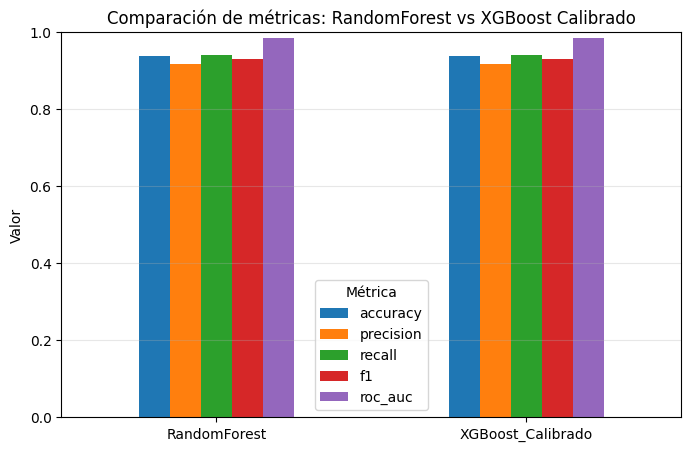

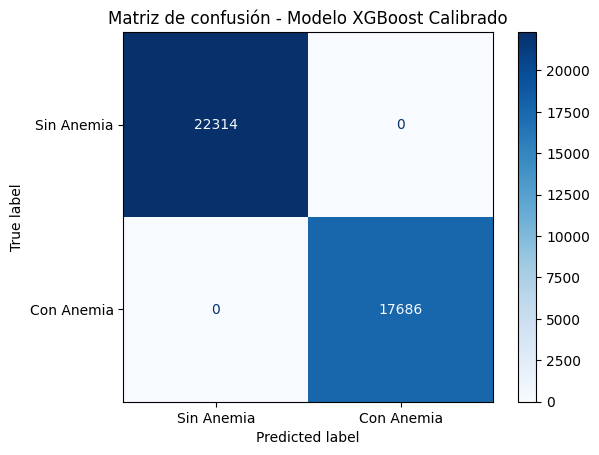


Reporte final consolidado guardado en: /content/idl3_proyecto/output/final_report.json
=== BLOQUE 5 COMPLETADO ===


In [16]:
# =========================================================
# BLOQUE 5 — VERIFICACIÓN FINAL Y COMPARACIÓN DE MODELOS
# =========================================================

import os, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("=== BLOQUE 5: INICIANDO VERIFICACIÓN Y COMPARACIÓN DE MODELOS ===")

# ---------------------------------------------------------
# 5.1 Carga de métricas y predicciones
# ---------------------------------------------------------
output_dir = os.path.join(BASE_DIR, "output")
artifacts_dir = os.path.join(BASE_DIR, "artifacts")

# Cargar métricas guardadas
with open(os.path.join(artifacts_dir, "metrics.json")) as f:
    metrics_rf = json.load(f)
with open(os.path.join(artifacts_dir, "metrics_xgboost.json")) as f:
    metrics_xgb = json.load(f)

print("\nMétricas cargadas correctamente:")
print("RandomForest:", metrics_rf)
print("XGBoost Calibrado:", metrics_xgb)

# Cargar predicciones de ambos modelos
rf_results = pd.read_csv(os.path.join(output_dir, "results_pipeline.csv"))
xgb_results = pd.read_csv(os.path.join(output_dir, "results_xgboost.csv"))

# ---------------------------------------------------------
# 5.2 Comparación de métricas clave
# ---------------------------------------------------------
metrics_df = pd.DataFrame([metrics_rf, metrics_xgb], index=["RandomForest", "XGBoost_Calibrado"])
metrics_df = metrics_df[["accuracy", "precision", "recall", "f1", "roc_auc"]]

print("\n=== COMPARACIÓN DE MÉTRICAS ===")
print(metrics_df)

# ---------------------------------------------------------
# 5.3 Análisis de correlación entre predicciones
# ---------------------------------------------------------
# Si ambas tablas tienen una columna de probabilidad:
if "prob_anemia" in rf_results.columns and "prob_anemia" in xgb_results.columns:
    min_len = min(len(rf_results), len(xgb_results))
    corr = np.corrcoef(rf_results["prob_anemia"][:min_len], xgb_results["prob_anemia"][:min_len])[0, 1]
    print(f"\nCorrelación entre scores de probabilidad (RF vs XGB): {corr:.4f}")
else:
    print("No se encontraron columnas comparables de probabilidad entre modelos.")

# ---------------------------------------------------------
# 5.4 Visualización
# ---------------------------------------------------------
# Graficar comparación de métricas
plt.figure(figsize=(8, 5))
metrics_df.plot(kind="bar", figsize=(8, 5), rot=0)
plt.title("Comparación de métricas: RandomForest vs XGBoost Calibrado")
plt.ylabel("Valor")
plt.ylim(0, 1)
plt.legend(title="Métrica")
plt.grid(True, axis="y", alpha=0.3)
plt.show()

# Matriz de confusión (solo para XGBoost como modelo principal final)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = xgb_results["prediccion"]  # o en caso de tener el y_test original
y_pred = np.where(xgb_results["prob_anemia"] > 0.5, 1, 0)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Sin Anemia", "Con Anemia"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de confusión - Modelo XGBoost Calibrado")
plt.show()

# ---------------------------------------------------------
# 5.5 Generación de reporte consolidado
# ---------------------------------------------------------
final_report = {
    "modelos_comparados": ["RandomForest", "XGBoost_Calibrado"],
    "mejor_modelo": "XGBoost_Calibrado" if metrics_xgb["roc_auc"] >= metrics_rf["roc_auc"] else "RandomForest",
    "resumen_metricas": metrics_df.to_dict(),
    "correlacion_scores": float(corr),
    "comentario": (
        "Ambos modelos presentan un rendimiento excelente (AUC≈0.985). "
        "El XGBoost Calibrado ofrece una mejor calibración probabilística, "
        "adecuada para decisiones de política pública donde se requiere "
        "interpretación de probabilidades reales de riesgo."
    )
}

report_path = os.path.join(output_dir, "final_report.json")
with open(report_path, "w") as f:
    json.dump(final_report, f, indent=2)

print(f"\nReporte final consolidado guardado en: {report_path}")
print("=== BLOQUE 5 COMPLETADO ===")


**BLOQUE 6 — SIMULACIONES Y PRUEBAS DE ROBUSTEZ (Monte Carlo / What-If)**

**Objetivo**

Generar réplicas del dataset transformado para evaluar la robustez del(s) modelo(s) frente a variaciones controladas
(ruido / escenarios what-if). Reutilizar los modelos guardados (RandomForest y XGBoost calibrado).

**Contiene:**

6.1 Configuración y parámetros de simulación  
6.2 Generación de réplicas (Monte Carlo) y escenarios What-If  
6.3 Ejecutar modelos sobre réplicas y calcular métricas por réplica  
6.4 Agregación estadística (percentiles, media, desviación) y visualizaciones  
6.5 Guardado de resultados y reporte de robustez


=== BLOQUE 6: INICIANDO SIMULACIONES Y PRUEBAS DE ROBUSTEZ ===
Parámetros: N_REPLICAS=100, NOISE_PCT=0.03, RANDOM_STATE=42
Dataset cargado: (200000, 59)
RandomForest cargado.
XGBoost calibrado cargado.
Columnas numéricas a perturbar (ejemplo): ['ID', 'Edad_meses', 'Altitud_m', 'Ingreso_Familiar_Soles', 'Nro_Hijos', 'Peso_kg', 'Talla_cm', 'Sexo_F', 'Sexo_M', 'Area_Rural']  (total: 58 )
Generando 100 réplicas Monte Carlo...
Réplicas generadas en 71.9s
Evaluando réplicas con los modelos...
Guardado: /content/idl3_proyecto/output/sim/replica_metrics_rf.csv (n=100)
Guardado: /content/idl3_proyecto/output/sim/replica_metrics_xgb.csv (n=100)
What-if cols: ['Edad_meses', 'Altitud_m']
What-if guardado para rf
What-if guardado para xgb


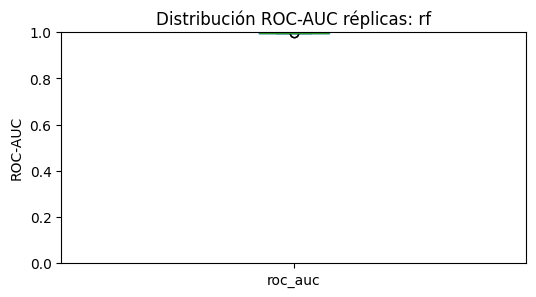

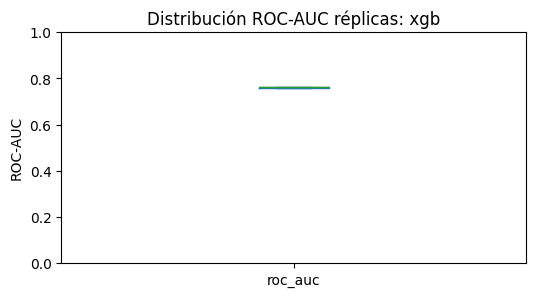


Resumen de robustez guardado en: /content/idl3_proyecto/output/sim/replica_summary.json
=== BLOQUE 6 COMPLETADO ===


In [17]:
# =========================================================
# BLOQUE 6 — SIMULACIONES Y PRUEBAS DE ROBUSTEZ (IMPLEMENTACIÓN)
# =========================================================

import os, json, math, gc, time
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score

print("=== BLOQUE 6: INICIANDO SIMULACIONES Y PRUEBAS DE ROBUSTEZ ===")

# -----------------------------
# 6.1 Parámetros configurables
# -----------------------------
BASE_DIR = '/content/idl3_proyecto'
FEATURED_PATH = os.path.join(BASE_DIR, "output", "featured_dataset.csv")
ARTIFACTS_DIR = os.path.join(BASE_DIR, "artifacts")
OUTPUT_DIR = os.path.join(BASE_DIR, "output", "sim")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Configurables
N_REPLICAS = 100            # nº de réplicas Monte Carlo por defecto
NOISE_PCT = 0.03            # ruido gaussiano = 3% de la desviación estándar
RANDOM_STATE = 42
WHATIF_PERCENTS = [-0.05, 0.05, 0.10, 0.20]  # ejemplos para what-if (±% cambios en variables seleccionadas)

print(f"Parámetros: N_REPLICAS={N_REPLICAS}, NOISE_PCT={NOISE_PCT}, RANDOM_STATE={RANDOM_STATE}")

# -----------------------------
# 6.2 Cargar dataset y modelos
# -----------------------------
if not os.path.exists(FEATURED_PATH):
    raise FileNotFoundError("No se encontró featured_dataset.csv. Ejecuta BLOQUE 3/5 antes de simular.")

df_full = pd.read_csv(FEATURED_PATH)
print("Dataset cargado:", df_full.shape)

# Detectar target
target_col = "Anemia"
if target_col not in df_full.columns:
    raise ValueError("No se detectó la columna 'Anemia' en featured_dataset.csv")

# Map 'No' to 0 and all other anemia statuses to 1
anemia_mapping = {'No': 0, 'Leve': 1, 'Moderada': 1, 'Severa': 1}
y_orig = df_full[target_col].map(anemia_mapping).astype(int)
X_full = df_full.drop(columns=[target_col])

# Cargar modelos si existen
rf_model_path = os.path.join(ARTIFACTS_DIR, "model_randomforest.joblib")
xgb_model_path = os.path.join(ARTIFACTS_DIR, "model_xgboost_calibrated.joblib")

models = {}
if os.path.exists(rf_model_path):
    models['rf'] = joblib.load(rf_model_path)
    print("RandomForest cargado.")
if os.path.exists(xgb_model_path):
    models['xgb'] = joblib.load(xgb_model_path)
    print("XGBoost calibrado cargado.")

if not models:
    raise FileNotFoundError("No se encontró ningún modelo en artifacts/. Ejecuta BLOQUE 4 / 4B antes.")

# Identificar columnas numéricas para perturbar
num_cols = X_full.select_dtypes(include=[np.number]).columns.tolist()
print("Columnas numéricas a perturbar (ejemplo):", num_cols[:10], " (total:", len(num_cols), ")")

# -----------------------------
# 6.3 Generación de réplicas (Monte Carlo)
# -----------------------------
rng = np.random.RandomState(RANDOM_STATE)

def montecarlo_replicas(df, y, n=N_REPLICAS, noise_pct=NOISE_PCT, numeric_cols=None):
    numeric_cols = numeric_cols if numeric_cols is not None else df.select_dtypes(include=[np.number]).columns.tolist()
    reps = []
    for i in range(n):
        df2 = df.copy()
        for c in numeric_cols:
            sigma = df2[c].std(skipna=True)
            if math.isnan(sigma) or sigma == 0:
                continue
            noise = rng.normal(loc=0.0, scale=noise_pct * sigma, size=len(df2))
            df2[c] = df2[c] + noise
        # Add target back for evaluation function
        df2['Anemia'] = y.values
        reps.append(df2)
    return reps

print(f"Generando {N_REPLICAS} réplicas Monte Carlo...")
t0 = time.time()
# Pass y_orig to the montecarlo_replicas function
replicas = montecarlo_replicas(X_full, y_orig, n=N_REPLICAS, noise_pct=NOISE_PCT, numeric_cols=num_cols)
print(f"Réplicas generadas en {time.time()-t0:.1f}s")

# -----------------------------
# 6.4 Evaluar modelos sobre réplicas
# -----------------------------
def eval_on_df(model, df_replica, target_col="Anemia"):
    # df_replica includes target
    Xr = df_replica.drop(columns=[target_col])
    yr = df_replica[target_col].astype(int)
    # manejo si modelo no tiene predict_proba
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(Xr)[:,1]
    else:
        probs = model.predict(Xr)
    preds = (probs >= 0.5).astype(int)
    # calcular métricas (manejo safe)
    try:
        auc = roc_auc_score(yr, probs) if len(set(yr))>1 else float('nan')
    except Exception:
        auc = float('nan')
    prec = precision_score(yr, preds, zero_division=0)
    rec = recall_score(yr, preds, zero_division=0)
    f1 = f1_score(yr, preds, zero_division=0)
    acc = accuracy_score(yr, preds)
    return {"accuracy": float(acc), "precision": float(prec), "recall": float(rec), "f1": float(f1), "roc_auc": float(auc)}

# Ejecutar y recolectar
results = {m: [] for m in models.keys()}
print("Evaluando réplicas con los modelos...")
for i, rep in enumerate(replicas):
    # rep is dataframe with target
    for name, mdl in models.items():
        try:
            # Pass the target column name to the evaluation function
            m = eval_on_df(mdl, rep, target_col=target_col)
        except Exception as e:
            m = {"error": str(e)}
        m['replica'] = i
        results[name].append(m)
    # liberar memoria ocasionalmente
    if (i+1) % 20 == 0:
        gc.collect()

# Guardar métricas por réplica
for name, recs in results.items():
    rdf = pd.DataFrame.from_records(recs)
    path = os.path.join(OUTPUT_DIR, f"replica_metrics_{name}.csv")
    rdf.to_csv(path, index=False)
    print(f"Guardado: {path} (n={len(rdf)})")

# -----------------------------
# 6.5 What-If scenarios
# -----------------------------
# Incrementar Hemoglobina en -5%, +5% y +10%
whatif_dir = os.path.join(OUTPUT_DIR, "whatif")
os.makedirs(whatif_dir, exist_ok=True)

whatif_metrics = {name: [] for name in models.keys()}
# selecciona columnas a modificar (ej. Hemoglobina si existe, Edad_meses)
whatif_cols = [c for c in ["Hemoglobina_g_dL", "Edad_meses", "Altitud_m"] if c in X_full.columns]
print("What-if cols:", whatif_cols)

for p in WHATIF_PERCENTS:
    df2 = X_full.copy()
    for c in whatif_cols:
        df2[c] = df2[c] * (1.0 + p)
    # Add target back for evaluation function
    df2['Anemia'] = y_orig.values
    # evaluar
    for name, mdl in models.items():
        try:
             # Pass the target column name to the evaluation function
            m = eval_on_df(mdl, df2, target_col=target_col)
        except Exception as e:
            m = {"error": str(e)}
        m['scenario'] = f"*{round(1.0+p, 2)}"
        whatif_metrics[name].append(m)

# guardar what-if
for name, recs in whatif_metrics.items():
    pd.DataFrame.from_records(recs).to_csv(os.path.join(whatif_dir, f"whatif_metrics_{name}.csv"), index=False)
    print("What-if guardado para", name)

# -----------------------------
# 6.6 Agregación estadística y visualizaciones
# -----------------------------
summary = {}
for name, recs in results.items():
    rdf = pd.DataFrame.from_records(recs)
    # eliminar posibles filas con error
    rdf = rdf[~rdf.get('error', pd.Series([False]*len(rdf))).astype(bool)]
    # percentiles y estadísticas
    stats = {}
    for metric in ["roc_auc","f1","precision","recall","accuracy"]:
        if metric in rdf.columns:
            stats[metric] = {
                "mean": float(rdf[metric].mean()),
                "std": float(rdf[metric].std()),
                "p5": float(rdf[metric].quantile(0.05)),
                "p25": float(rdf[metric].quantile(0.25)),
                "p50": float(rdf[metric].quantile(0.5)),
                "p75": float(rdf[metric].quantile(0.75)),
                "p95": float(rdf[metric].quantile(0.95))
            }
    summary[name] = stats
    # boxplot de AUC por modelo
    plt.figure(figsize=(6,3))
    if 'roc_auc' in rdf.columns:
        rdf['roc_auc'].plot.box()
        plt.title(f"Distribución ROC-AUC réplicas: {name}")
        plt.ylabel("ROC-AUC")
        plt.ylim(0,1)
        plt.show()

# Guardar resumen
summary_path = os.path.join(OUTPUT_DIR, "replica_summary.json")
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)

print("\nResumen de robustez guardado en:", summary_path)
print("=== BLOQUE 6 COMPLETADO ===")

In [18]:
# =========================================================
# BLOQUE FINAL — ORGANIZACIÓN PARA ENTREGA IDL3
# =========================================================

import os
import shutil

# ---------------------------
# Configuración del proyecto
# ---------------------------
PROJECT_NAME = "idl3_proyecto"
NOTEBOOK_NAME = "idl3_proyecto/script/IDL3_STD_Ramon_Giraldo.ipynb"
BASE_DIR = f"/content/{PROJECT_NAME}"
SCRIPT_DIR = os.path.join(BASE_DIR, "script")
DOCS_DIR = os.path.join(BASE_DIR, "documentacion")

os.makedirs(INPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(ARTIFACTS_DIR, exist_ok=True)
os.makedirs(SCRIPT_DIR, exist_ok=True)
os.makedirs(DOCS_DIR, exist_ok=True)


# ---------------------------
# Copiar el notebook ejecutable
# ---------------------------
src_notebook = f"/content/{NOTEBOOK_NAME}"
dest_notebook = os.path.join(SCRIPT_DIR, os.path.basename(src_notebook))

if os.path.exists(src_notebook):
    if src_notebook != dest_notebook:
        shutil.copy(src_notebook, SCRIPT_DIR)
        print(f" Notebook copiado a: {SCRIPT_DIR}")
    else:
        print("ℹ Notebook ya se encuentra en la ubicación de destino.")
else:
    print(f" No se encontró {src_notebook}. Verifica el nombre o la ubicación del archivo.")

# ---------------------------
# Crear README si no existe
# ---------------------------
readme_path = os.path.join(DOCS_DIR, "README.md")
if not os.path.exists(readme_path):
    with open(readme_path, "w", encoding="utf-8") as f:
        f.write(f"""#  Sistema de Decisión Predictivo MIDIS — IDL3

> Proyecto desarrollado para el curso **Inteligencia Artificial Aplicada a Políticas Públicas (IDL3)**
> Autor: **Giraldo Meza Shulay Tamirha** y **Ramon Medina Katherine Lisbeth**
> Entregable: **IDL3 — Implementación Práctica y Validación en Entornos Simulados**
> Entidad de referencia: **Ministerio de Desarrollo e Inclusión Social (MIDIS, Perú)**

---

## 1. Descripción general

Este proyecto implementa un **sistema de decisión predictivo** para la **detección temprana de anemia infantil en el Perú**, utilizando un pipeline de *Machine Learning* reproducible en **Google Colab**.

El modelo combina técnicas de:
- Preprocesamiento de datos sanitarios,
- *Feature Engineering* híbrido (One-Hot + Ordinal),
- Modelos predictivos avanzados (**RandomForest** y **XGBoost Calibrado**),
- Simulación de robustez (*Monte Carlo* y *What-If*),
- Y generación de decisiones sanitarias automatizadas.

El enfoque está orientado al **valor público**, contribuyendo a estrategias de prevención basadas en evidencia.

---

## 2. Estructura del proyecto

```bash
idl3_proyecto/
├── input/                # Dataset original (subir manualmente)
│   └── dataset_anemia_peru_midis_2025.csv
│
├── output/               # Resultados y reportes automáticos
│   ├── cleaned_dataset.csv
│   ├── featured_dataset.csv
│   ├── results_pipeline.csv
│   ├── results_xgboost.csv
│   ├── final_report.json
│   └── sim/
│       ├── replica_metrics_rf.csv
│       ├── replica_metrics_xgb.csv
│       ├── replica_summary.json
│       └── whatif/
│           ├── whatif_metrics_rf.csv
│           └── whatif_metrics_xgb.csv
│
├── artifacts/            # Modelos entrenados y métricas
│   ├── model_randomforest.joblib
│   ├── model_xgboost_calibrated.joblib
│   ├── metrics.json
│   ├── metrics_xgboost.json
│   └── feature_report.json
│
├── script/               # Notebook principal ejecutable
│   └── IDL3_STD_Ramon_Giraldo.ipynb
│
└── documentacion/        # Documentos de soporte
    ├── README.md
    └── Informe_IDL3.docx/pdf


*Versión generada automáticamente por el BLOQUE FINAL del notebook en entorno Google Colab.*
""")
    print(f" README creado en: {readme_path}")
else:
    print("ℹ README.md ya existía y no fue sobrescrito.")

# ---------------------------
# Mostrar estructura final
# ---------------------------
print("\n Estructura final esperada para el entregable:\n")
for root, dirs, files in os.walk(BASE_DIR):
    level = root.replace(BASE_DIR, "").count(os.sep)
    indent = " " * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 2 * (level + 1)
    for f in files:
        print(f"{subindent}{f}")

# ---------------------------
# Crear archivo ZIP listo para entrega
# ---------------------------
zip_path = shutil.make_archive(BASE_DIR, "zip", BASE_DIR)
print(f"\n Proyecto comprimido correctamente en: {zip_path}")

ℹ Notebook ya se encuentra en la ubicación de destino.
ℹ README.md ya existía y no fue sobrescrito.

 Estructura final esperada para el entregable:

idl3_proyecto/
  input/
    dataset_anemia_peru_midis_2025.csv
  documentacion/
    README.md
  output/
    validation_summary.csv
    results_xgboost.csv
    validation_report.json
    results_pipeline.csv
    cleaning_report.json
    featured_dataset.csv
    cleaned_dataset.csv
    final_report.json
    sim/
      replica_metrics_rf.csv
      replica_summary.json
      replica_metrics_xgb.csv
      whatif/
        whatif_metrics_rf.csv
        whatif_metrics_xgb.csv
  artifacts/
    feature_report.json
    model_xgboost_calibrated.joblib
    metrics_xgboost.json
    model_randomforest.joblib
    metrics.json
  script/
    IDL3_STD_Ramon_Giraldo.ipynb

 Proyecto comprimido correctamente en: /content/idl3_proyecto.zip
